# Module 1.1: Introduction to LangGraph
## GenAI Expert Course

---

**Learning Objectives:**
- Understand how LangGraph differs from LangChain and LlamaIndex
- Identify when to use LangGraph for stateful, cyclical workflows
- Master core concepts: Graphs, Nodes, Edges, and State
- Learn DAG-based orchestration fundamentals
- Set up and verify your development environment

**Duration:** 2-3 hours

---

## Section 1: Environment Setup

Let's start by setting up our environment and installing necessary packages.

In [1]:
# Install required packages (run this once)
!pip install -q langgraph langchain langchain-anthropic langchain-openai python-dotenv

In [5]:
# Import necessary libraries
import os
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END, START
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
import warnings
warnings.filterwarnings('ignore')

print("All imports successful!")

All imports successful!


In [30]:
# Set up API keys (replace with your actual keys or use .env file)
# Option 1: Set directly (not recommended for production)
# os.environ["ANTHROPIC_API_KEY"] = "your-key-here"
# os.environ["OPENAI_API_KEY"] = "your-key-here"

# Option 2: Load from .env file (recommended)
from dotenv import load_dotenv
load_dotenv()

# Verify keys are set (shows first 10 characters only)
anthropic_key = os.getenv("ANTHROPIC_API_KEY", "")
openai_key = os.getenv("OPENAI_API_KEY", "")

print(f"Anthropic API Key: {' Set' if anthropic_key else ' Not set'}")
print(f"OpenAI API Key: {' Set' if openai_key else ' Not set'}")
print("\n  Note: You need at least one API key set to run LLM examples")

Anthropic API Key:  Set
OpenAI API Key:  Set

  Note: You need at least one API key set to run LLM examples


---

## Section 2: LangGraph vs LangChain vs LlamaIndex

### Understanding the Ecosystem

Before diving into LangGraph, let's understand how it fits into the broader GenAI framework landscape:

| Feature | LangChain | LlamaIndex | LangGraph |
|---------|-----------|------------|-----------|
| **Execution Model** | Linear chains | Query-focused | Cyclical graphs |
| **State Management** | Limited | Session-based | Full persistence |
| **Control Flow** | Sequential | Router-based | Arbitrary graphs |
| **Multi-Agent** | Basic | Limited | Advanced |
| **RAG Capabilities** | Good | Excellent | Good (via integration) |
| **Best For** | Simple apps | Document QA | Complex agents |

### Key Principle
**LangChain** = Building blocks  
**LlamaIndex** = RAG specialist  
**LangGraph** = Orchestration engine for complex, stateful workflows

### Demo: LangChain vs LangGraph for Simple Task

Let's compare how a simple task looks in both frameworks:

In [19]:
from anthropic import Anthropic

client = Anthropic()

msg = client.messages.create(
    model="claude-3-haiku-20240307",
    max_tokens=50,
    messages=[{"role": "user", "content": "Say hello"}]
)

print(msg.content[0].text)

Hello!


In [23]:
# LANGCHAIN APPROACH - Simple Linear Chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Initialize LLM
llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)

# Create a simple chain
prompt = ChatPromptTemplate.from_template("Tell me a joke about {topic}")
chain = prompt | llm | StrOutputParser()

# Execute
result = chain.invoke({"topic": "programming"})
print(" LangChain Result:")
print(result)
print("\n LangChain: Great for simple, linear workflows!")

 LangChain Result:
Here's a programming joke for you:

Why do programmers always mix up Halloween and Christmas?
Because Oct 31 equals Dec 25!

Get it? Oct 31 (October 31st) sounds like "octal 31" which is equal to the decimal number 25, which is December 25th. It's a play on programming concepts like octal numbers and equality operators. Programmers tend to appreciate these kinds of geeky, pun-based jokes. Hopefully you found it amusing!

 LangChain: Great for simple, linear workflows!


In [34]:
# LANGGRAPH APPROACH - Same task but with graph structure
from langgraph.graph import StateGraph, END

# Define state
class SimpleState(TypedDict):
    topic: str
    joke: str

# Define node
def joke_node(state: SimpleState):
    """Generate a joke based on topic"""
    llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)
    result = llm.invoke(f"Tell me a joke about {state['topic']}")
    return {"joke": result.content}

# Build graph
#============================================================
# Create a state-based graph
# StateGraph defines how data (state) flows between nodes
# SimpleState is the schema that holds and tracks shared state
graph = StateGraph(SimpleState)

# Add a node (step) to the graph
# "generate_joke" is the node name
# joke_node is the function that runs at this step
# The function takes state as input and returns updated state
graph.add_node("generate_joke", joke_node)

# Define where execution should START
# This is the first node that runs when graph.invoke() is called
graph.set_entry_point("generate_joke")

# Define how execution ENDS
# After generate_joke finishes, the graph moves to END
# END is a built-in terminal state in LangGraph
graph.add_edge("generate_joke", END)


# Compile and run
app = graph.compile()
result = app.invoke({"topic": "programming"})

print(" LangGraph Result:")
print(result["joke"])
print("\n LangGraph: More verbose but enables complex workflows!")

 LangGraph Result:
Here's a programming joke for you:

Why do programmers always mix up Halloween and Christmas?
Because Oct 31 equals Dec 25!

Get it? Oct 31 (October 31st) sounds like "octal 31" which is equal to the decimal number 25, which is December 25th. It's a play on programming concepts like octal numbers and equality comparisons. Programmers tend to appreciate these kinds of geeky, pun-based jokes.

 LangGraph: More verbose but enables complex workflows!


### 💡 Key Insight

For this simple task, **LangChain is more concise**. But LangGraph shines when you need:
- **Loops** (retry logic, iterative improvement)
- **Branching** (conditional logic based on state)
- **State persistence** (memory across interactions)
- **Multi-agent coordination**

---

## Section 3: When to Use LangGraph

### ✅ Use LangGraph When You Need:

1. **Stateful Conversations** - Remember context across turns
2. **Cyclical Workflows** - Loops, retries, iterative refinement
3. **Multi-Agent Systems** - Multiple specialized agents collaborating
4. **Human-in-the-Loop** - Approval gates, feedback loops
5. **Complex Branching** - Dynamic routing based on conditions

### ❌ Don't Use LangGraph For:

1. Simple Q&A → Use LangChain
2. Basic RAG → Use LlamaIndex
3. One-shot completions → Use OpenAI/Anthropic SDK directly
4. Static document processing → Use LangChain

### Real-World Examples:

#### Example 1: Code Generator with Testing Loop (Cyclical)

In [39]:
# Simplified demonstration of cyclical workflow
class CodeGenState(TypedDict):
    requirement: str
    code: str
    test_result: str
    iterations: int
    max_iterations: int

def generate_code(state: CodeGenState):
    """Generate code based on requirement"""
    print(f"\n Iteration {state['iterations'] + 1}: Generating code...")
    # Simulate code generation
    code = f"def solution(): # Attempt {state['iterations'] + 1}\n    return 42"
    return {"code": code, "iterations": state["iterations"] + 1}

def test_code(state: CodeGenState):
    """Test the generated code"""
    print(f"    Testing code...")
    # Simulate test (fail first time, pass second time)
    if state["iterations"] < 2:
        result = "FAILED: Function should return 100, got 42"
    else:
        result = "PASSED"
    print(f"   Result: {result}")
    return {"test_result": result}

def should_continue(state: CodeGenState) -> str:
    """Decide whether to retry or finish"""
    if "PASSED" in state["test_result"]:
        return "finish"
    elif state["iterations"] >= state["max_iterations"]:
        return "finish"
    else:
        return "retry"

# Build the graph with a LOOP
workflow = StateGraph(CodeGenState)
workflow.add_node("generate", generate_code)
workflow.add_node("test", test_code)

workflow.set_entry_point("generate")
workflow.add_edge("generate", "test")

# CONDITIONAL EDGE - This creates the LOOP!
workflow.add_conditional_edges(
    "test",
    should_continue,
    {
        "retry": "generate",  # Loop back to generate
        "finish": END
    }
)

# Compile and run
app = workflow.compile()
result = app.invoke({
    "requirement": "Create a function that returns 100",
    "code": "",
    "test_result": "",
    "iterations": 0,
    "max_iterations": 3
})

print("\n Final Result:")
print(f"Total iterations: {result['iterations']}")
print(f"Test result: {result['test_result']}")
print("\n This LOOP pattern is impossible in basic LangChain chains!")


 Iteration 1: Generating code...
    Testing code...
   Result: FAILED: Function should return 100, got 42

 Iteration 2: Generating code...
    Testing code...
   Result: PASSED

 Final Result:
Total iterations: 2
Test result: PASSED

 This LOOP pattern is impossible in basic LangChain chains!


---

## Section 4: Core Concepts Deep Dive

### 4.1 The Four Pillars of LangGraph

```
┌─────────────────────────────────────┐
│           GRAPH                     │
│  ┌──────────┐      ┌──────────┐   │
│  │  NODE 1  │─────▶│  NODE 2  │   │
│  └──────────┘      └──────────┘   │
│       │                  │         │
│       ▼                  ▼         │
│    [STATE]            [STATE]      │
└─────────────────────────────────────┘
```

1. **GRAPH** = Container for your workflow
2. **NODES** = Functions that do work
3. **EDGES** = Connections between nodes
4. **STATE** = Data that flows through

### 4.2 Understanding State

In [41]:
# State is a TypedDict that defines your data structure
from typing import TypedDict, Annotated
from operator import add

class AgentState(TypedDict):
    # Simple field - gets overwritten
    current_step: str
    
    # Counter that accumulates
    total_count: Annotated[int, add]
    
    # List that appends (using add operator)
    history: Annotated[list, add]

# Demonstrate state updates
def node_1(state: AgentState):
    print(f"Node 1 executing... current_step: {state.get('current_step', 'none')}")
    return {
        "current_step": "step_1",
        "total_count": 10,
        "history": ["node_1 executed"]
    }

def node_2(state: AgentState):
    print(f"Node 2 executing... current_step: {state['current_step']}")
    return {
        "current_step": "step_2",  # Overwrites step_1
        "total_count": 15,          # Adds to 10, becomes 25
        "history": ["node_2 executed"]  # Appends to list
    }

# Build graph
state_demo = StateGraph(AgentState)
state_demo.add_node("n1", node_1)
state_demo.add_node("n2", node_2)
state_demo.set_entry_point("n1")
state_demo.add_edge("n1", "n2")
state_demo.add_edge("n2", END)

app = state_demo.compile()
result = app.invoke({"current_step": "start", "total_count": 0, "history": []})

print("\n Final State:")
print(f"current_step: {result['current_step']}  # Overwritten")
print(f"total_count: {result['total_count']}  # Added: 10 + 15 = 25")
print(f"history: {result['history']}  # Appended")

print("\n Key Insight: Annotated types control how state is merged!")

Node 1 executing... current_step: start
Node 2 executing... current_step: step_1

 Final State:
current_step: step_2  # Overwritten
total_count: 25  # Added: 10 + 15 = 25
history: ['node_1 executed', 'node_2 executed']  # Appended

 Key Insight: Annotated types control how state is merged!


### 4.3 Understanding Nodes

In [45]:
# Nodes are just Python functions that:
# 1. Take state as input
# 2. Do some work
# 3. Return state updates

class SimpleState(TypedDict):
    input_text: str
    result: str
    step_count: int

def processing_node(state: SimpleState):
    """A node can do ANY Python operation"""
    print(f"Processing: {state['input_text']}")
    
    # Example operations:
    # - Call an LLM
    # - Query a database
    # - Make an API call
    # - Run calculations
    # - Execute any Python code
    
    processed = state['input_text'].upper()
    
    # Return UPDATES (not the full state)
    return {
        "result": processed,
        "step_count": state.get('step_count', 0) + 1
    }

def analysis_node(state: SimpleState):
    """Another node that builds on previous results"""
    print(f"Analyzing: {state['result']}")
    analysis = f"Length: {len(state['result'])} characters"
    return {
        "result": state['result'] + f" ({analysis})",
        "step_count": state['step_count'] + 1
    }

# Build graph
node_demo = StateGraph(SimpleState)
node_demo.add_node("process", processing_node)
node_demo.add_node("analyze", analysis_node)
node_demo.set_entry_point("process")
node_demo.add_edge("process", "analyze")
node_demo.add_edge("analyze", END)

app = node_demo.compile()
result = app.invoke({"input_text": "hello world", "result": "", "step_count": 0})

print("\n Final Result:")
print(f"Result: {result['result']}")
print(f"Steps: {result['step_count']}")
print("\n Nodes are the WORKERS in your graph!")

Processing: hello world
Analyzing: HELLO WORLD

 Final Result:
Result: HELLO WORLD (Length: 11 characters)
Steps: 2

 Nodes are the WORKERS in your graph!


### 4.4 Understanding Edges

In [47]:
# Three types of edges in LangGraph

class EdgeDemoState(TypedDict):
    value: int
    path_taken: str

# Define some nodes
def start_node(state: EdgeDemoState):
    print("▶️  Start node")
    return {"path_taken": "start"}

def path_a_node(state: EdgeDemoState):
    print("   🅰️  Path A taken")
    return {"path_taken": "path_a"}

def path_b_node(state: EdgeDemoState):
    print("   🅱️  Path B taken")
    return {"path_taken": "path_b"}

def end_node(state: EdgeDemoState):
    print("🏁 End node")
    return {"path_taken": state['path_taken'] + "->end"}

# Routing function for conditional edge
def route_based_on_value(state: EdgeDemoState) -> str:
    """Route to different nodes based on state"""
    if state['value'] > 5:
        return "path_a"
    else:
        return "path_b"

# Build graph with different edge types
edge_demo = StateGraph(EdgeDemoState)
edge_demo.add_node("start", start_node)
edge_demo.add_node("path_a", path_a_node)
edge_demo.add_node("path_b", path_b_node)
edge_demo.add_node("end", end_node)

# 1. ENTRY POINT - where to start
edge_demo.set_entry_point("start")

# 2. CONDITIONAL EDGE - dynamic routing
edge_demo.add_conditional_edges(
    "start",
    route_based_on_value,
    {
        "path_a": "path_a",
        "path_b": "path_b"
    }
)

# 3. NORMAL EDGES - direct connections
edge_demo.add_edge("path_a", "end")
edge_demo.add_edge("path_b", "end")
edge_demo.add_edge("end", END)

app = edge_demo.compile()

# Test with different values
print("Test 1: value = 8 (should go to path_a)")
result1 = app.invoke({"value": 8, "path_taken": ""})
print(f"Path: {result1['path_taken']}\n")

print("Test 2: value = 3 (should go to path_b)")
result2 = app.invoke({"value": 3, "path_taken": ""})
print(f"Path: {result2['path_taken']}")

print("\n💡 Conditional edges enable dynamic, intelligent routing!")

Test 1: value = 8 (should go to path_a)
▶️  Start node
   🅰️  Path A taken
🏁 End node
Path: path_a->end

Test 2: value = 3 (should go to path_b)
▶️  Start node
   🅱️  Path B taken
🏁 End node
Path: path_b->end

💡 Conditional edges enable dynamic, intelligent routing!


### 4.5 Putting It All Together: Complete Example

In [53]:
# Let's build a simple chatbot with memory and retry logic
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

class ChatbotState(TypedDict):
    messages: list  # Conversation history
    retry_count: int
    response_quality: str  # 'good' or 'needs_improvement'

# Initialize LLM
llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0.7)

def generate_response(state: ChatbotState):
    """Generate a response using LLM"""
    print(f"\n🤖 Generating response (attempt {state['retry_count'] + 1})...")
    
    messages = state['messages']
    response = llm.invoke(messages)
    
    return {
        "messages": messages + [AIMessage(content=response.content)],
        "retry_count": state['retry_count'] + 1
    }

def evaluate_response(state: ChatbotState):
    """Check if response is good enough"""
    last_message = state['messages'][-1].content
    
    # Simple heuristic: check length
    if len(last_message) > 50:
        quality = "good"
        print("   ✅ Response quality: GOOD")
    else:
        quality = "needs_improvement"
        print("   ⚠️  Response quality: NEEDS IMPROVEMENT")
    
    return {"response_quality": quality}

def should_retry(state: ChatbotState) -> str:
    """Decide whether to retry or finish"""
    if state['response_quality'] == 'good':
        return "finish"
    elif state['retry_count'] >= 2:
        return "finish"  # Max retries reached
    else:
        return "retry"

# Build the graph
chatbot = StateGraph(ChatbotState)
chatbot.add_node("generate", generate_response)
chatbot.add_node("evaluate", evaluate_response)

chatbot.set_entry_point("generate")
chatbot.add_edge("generate", "evaluate")
chatbot.add_conditional_edges(
    "evaluate",
    should_retry,
    {
        "retry": "generate",
        "finish": END
    }
)

app = chatbot.compile()

# Test it
initial_state = {
    "messages": [HumanMessage(content="Tell me about LangGraph in detail.")],
    "retry_count": 0,
    "response_quality": ""
}

result = app.invoke(initial_state)

print("\n" + "="*60)
print("FINAL CONVERSATION")
print("="*60)
for msg in result['messages']:
    role = "👤 User" if isinstance(msg, HumanMessage) else "🤖 Assistant"
    print(f"\n{role}:")
    print(msg.content[:200] + "..." if len(msg.content) > 200 else msg.content)

print(f"\n📊 Stats: {result['retry_count']} attempt(s), Quality: {result['response_quality']}")
print("\n💡 This demonstrates: STATE + NODES + EDGES + LOOPS working together!")


🤖 Generating response (attempt 1)...
   ✅ Response quality: GOOD

FINAL CONVERSATION

👤 User:
Tell me about LangGraph in detail.

🤖 Assistant:
I do not have detailed information about a system called "LangGraph". As an AI assistant, I do not have specific knowledge about every language modeling or natural language processing system that may ...

📊 Stats: 1 attempt(s), Quality: good

💡 This demonstrates: STATE + NODES + EDGES + LOOPS working together!


---

## Section 5: DAG-Based Orchestration

### What is a DAG?

**DAG = Directed Acyclic Graph**
- **Directed**: Edges have direction (A → B)
- **Acyclic**: No infinite loops in structure (though LangGraph allows cycles!)

### Graph Compilation Process

When you call `graph.compile()`, LangGraph:
1. ✅ Validates the graph structure
2. ✅ Ensures all nodes are reachable
3. ✅ Creates execution plan
4. ✅ Sets up state management
5. ✅ Returns runnable application

In [55]:
# Demonstrate graph compilation and inspection
from langgraph.graph import StateGraph, END

class DemoState(TypedDict):
    data: str

def node_a(state): return {"data": "A"}
def node_b(state): return {"data": "B"}
def node_c(state): return {"data": "C"}

# Build graph
graph = StateGraph(DemoState)
graph.add_node("a", node_a)
graph.add_node("b", node_b)
graph.add_node("c", node_c)

graph.set_entry_point("a")
graph.add_edge("a", "b")
graph.add_edge("b", "c")
graph.add_edge("c", END)

# Compile
print("📦 Compiling graph...")
app = graph.compile()
print("✅ Graph compiled successfully!")

# Inspect the graph
print("\n📊 Graph Structure:")
print(f"Nodes: {list(graph.nodes.keys())}")

# Run it
print("\n▶️  Executing graph...")
result = app.invoke({"data": "start"})
print(f"✅ Final state: {result}")

print("\n💡 The compiled graph is a runnable application!")

📦 Compiling graph...
✅ Graph compiled successfully!

📊 Graph Structure:
Nodes: ['a', 'b', 'c']

▶️  Executing graph...
✅ Final state: {'data': 'C'}

💡 The compiled graph is a runnable application!


### State Reducers in Action

In [57]:
# Advanced state management with custom reducers
from typing import Annotated
from operator import add

def multiply(a, b):
    """Custom reducer that multiplies values"""
    return a * b

class AdvancedState(TypedDict):
    # Default behavior: overwrite
    status: str
    
    # Add values together
    total: Annotated[int, add]
    
    # Multiply values
    multiplier: Annotated[int, multiply]
    
    # Append to list
    log: Annotated[list, add]

def node_1(state: AdvancedState):
    return {
        "status": "processing",
        "total": 10,
        "multiplier": 2,
        "log": ["node_1"]
    }

def node_2(state: AdvancedState):
    return {
        "status": "complete",  # Overwrites "processing"
        "total": 25,            # Adds: 10 + 25 = 35
        "multiplier": 3,        # Multiplies: 2 * 3 = 6
        "log": ["node_2"]      # Appends to list
    }

# Build and run
reducer_demo = StateGraph(AdvancedState)
reducer_demo.add_node("n1", node_1)
reducer_demo.add_node("n2", node_2)
reducer_demo.set_entry_point("n1")
reducer_demo.add_edge("n1", "n2")
reducer_demo.add_edge("n2", END)

app = reducer_demo.compile()
result = app.invoke({
    "status": "initial",
    "total": 0,
    "multiplier": 1,
    "log": []
})

print(" Final State:")
print(f"  status: {result['status']} (overwritten)")
print(f"  total: {result['total']} (added: 0 + 10 + 25)")
print(f"  multiplier: {result['multiplier']} (multiplied: 1 * 2 * 3)")
print(f"  log: {result['log']} (appended)")

print("\n Reducers give you fine-grained control over state merging!")

 Final State:
  status: complete (overwritten)
  total: 35 (added: 0 + 10 + 25)
  multiplier: 0 (multiplied: 1 * 2 * 3)
  log: ['node_1', 'node_2'] (appended)

 Reducers give you fine-grained control over state merging!


---

## Section 6: Real-World Example - Research Assistant

Let's build a more realistic example that combines everything we've learned:

In [63]:
# Research Assistant with multiple stages
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

class ResearchState(TypedDict):
    query: str
    search_results: str
    analysis: str
    final_report: str
    iterations: int
    quality_score: int

# Initialize LLM
research_llm = ChatAnthropic(model="claude-3-haiku-20240307", temperature=0)

def search_node(state: ResearchState):
    """Simulate web search"""
    print(f"\n Searching for: {state['query']}")
    # In real implementation, this would call a search API
    search_results = f"Mock search results for '{state['query']}': LangGraph is a framework for building stateful, multi-agent applications."
    return {"search_results": search_results}

def analyze_node(state: ResearchState):
    """Analyze search results"""
    print(" Analyzing results...")
    
    prompt = f"""
    Analyze these search results and provide key insights:
    {state['search_results']}
    
    Provide a concise analysis.
    """
    
    response = research_llm.invoke([HumanMessage(content=prompt)])
    return {"analysis": response.content}

def generate_report(state: ResearchState):
    """Generate final report"""
    print(" Generating report...")
    
    prompt = f"""
    Create a brief research report based on:
    
    Query: {state['query']}
    Analysis: {state['analysis']}
    
    Keep it concise (2-3 sentences).
    """
    
    response = research_llm.invoke([HumanMessage(content=prompt)])
    return {
        "final_report": response.content,
        "iterations": state['iterations'] + 1
    }

def evaluate_quality(state: ResearchState):
    """Evaluate report quality"""
    print(" Evaluating quality...")
    # Simple heuristic
    score = len(state['final_report']) // 50  # Rough quality score
    print(f"   Quality score: {score}/10")
    return {"quality_score": score}

def should_refine(state: ResearchState) -> str:
    """Decide if we need to refine"""
    if state['quality_score'] >= 3 or state['iterations'] >= 2:
        return "finish"
    return "refine"

# Build the research workflow
research_graph = StateGraph(ResearchState)

# Add all nodes
research_graph.add_node("search", search_node)
research_graph.add_node("analyze", analyze_node)
research_graph.add_node("report", generate_report)
research_graph.add_node("evaluate", evaluate_quality)

# Define the flow
research_graph.set_entry_point("search")
research_graph.add_edge("search", "analyze")
research_graph.add_edge("analyze", "report")
research_graph.add_edge("report", "evaluate")

# Conditional: refine or finish
research_graph.add_conditional_edges(
    "evaluate",
    should_refine,
    {
        "refine": "analyze",  # Loop back to improve
        "finish": END
    }
)

# Compile and run
research_app = research_graph.compile()

result = research_app.invoke({
    "query": "What is LangGraph?",
    "search_results": "",
    "analysis": "",
    "final_report": "",
    "iterations": 0,
    "quality_score": 0
})

print("\n" + "="*60)
print("RESEARCH REPORT")
print("="*60)
print(f"\nQuery: {result['query']}")
print(f"\nReport:\n{result['final_report']}")
print(f"\nIterations: {result['iterations']}")
print(f"Quality Score: {result['quality_score']}/10")

print("\n This example shows a complete multi-stage workflow with quality checks!")


 Searching for: What is LangGraph?
 Analyzing results...
 Generating report...
 Evaluating quality...
   Quality score: 9/10

RESEARCH REPORT

Query: What is LangGraph?

Report:
LangGraph is a framework for building stateful, multi-agent applications. It provides a set of tools, libraries, and guidelines to support the development of complex, distributed systems that involve multiple autonomous components or agents. The framework's focus on stateful, multi-agent applications suggests that it could be useful for a wide range of applications, such as collaborative platforms, distributed systems, or even artificial intelligence systems.

Iterations: 1
Quality Score: 9/10

 This example shows a complete multi-stage workflow with quality checks!


---

## Section 7: Visualization and Debugging

Understanding how to visualize and debug your graphs is crucial.

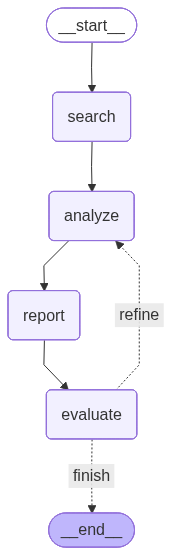

✅ Graph visualization displayed above!


In [65]:
# Let's visualize our research graph structure
try:
    from IPython.display import Image, display
    
    # Generate graph visualization
    display(Image(research_app.get_graph().draw_mermaid_png()))
    print("✅ Graph visualization displayed above!")
except Exception as e:
    print(f"⚠️  Visualization requires additional setup: {e}")
    print("\nGraph structure (text format):")
    print("search → analyze → report → evaluate")
    print("                              ↓")
    print("                         (conditional)")
    print("                         ↓         ↓")
    print("                      refine      END")
    print("                         ↓")
    print("                      analyze (loop)")

In [67]:
# Debugging: Stream intermediate results
print("🔍 Streaming graph execution (step by step):\n")

for i, step in enumerate(research_app.stream({
    "query": "What is LangGraph?",
    "search_results": "",
    "analysis": "",
    "final_report": "",
    "iterations": 0,
    "quality_score": 0
}), 1):
    print(f"Step {i}:")
    for key, value in step.items():
        print(f"  Node: {key}")
        if isinstance(value, dict):
            for k, v in value.items():
                if isinstance(v, str) and len(v) > 100:
                    print(f"    {k}: {v[:100]}...")
                else:
                    print(f"    {k}: {v}")
    print()

print("💡 Streaming helps you debug by showing each node's execution!")

🔍 Streaming graph execution (step by step):


 Searching for: What is LangGraph?
Step 1:
  Node: search
    search_results: Mock search results for 'What is LangGraph?': LangGraph is a framework for building stateful, multi-...

 Analyzing results...
Step 2:
  Node: analyze
    analysis: Based on the provided search result, the key insights are:

1. LangGraph is a framework: The search ...

 Generating report...
Step 3:
  Node: report
    final_report: LangGraph is a framework for building stateful, multi-agent applications. It provides a set of tools...
    iterations: 1

 Evaluating quality...
   Quality score: 9/10
Step 4:
  Node: evaluate
    quality_score: 9

💡 Streaming helps you debug by showing each node's execution!


---

## Section 8: Best Practices & Common Pitfalls

### ✅ Best Practices

1. **Start Simple** - Begin with linear graphs, add complexity gradually
2. **Use TypedDict** - Helps catch errors early with type checking
3. **Keep Nodes Focused** - Each node should do ONE thing well
4. **Test Individually** - Test nodes independently before combining
5. **Use Reducers Wisely** - Choose appropriate merge strategies for your state

### ❌ Common Pitfalls

1. **Over-complicating** - Don't use LangGraph for simple linear tasks
2. **State Bloat** - Keep state minimal, only include what you need
3. **Missing END** - Always ensure paths lead to END
4. **Ignoring Errors** - Add proper error handling in nodes
5. **No Validation** - Validate state structure early

In [69]:
# Example: Error handling in nodes
class SafeState(TypedDict):
    value: int
    error: str
    success: bool

def risky_operation(state: SafeState):
    """Node with proper error handling"""
    try:
        # Simulate operation that might fail
        result = 100 // state['value']  # Division
        return {"value": result, "success": True, "error": ""}
    except ZeroDivisionError:
        return {"success": False, "error": "Cannot divide by zero"}
    except Exception as e:
        return {"success": False, "error": str(e)}

def handle_result(state: SafeState):
    if state['success']:
        print(f"✅ Operation successful: {state['value']}")
    else:
        print(f"❌ Operation failed: {state['error']}")
    return {}

# Build graph
safe_graph = StateGraph(SafeState)
safe_graph.add_node("operate", risky_operation)
safe_graph.add_node("handle", handle_result)
safe_graph.set_entry_point("operate")
safe_graph.add_edge("operate", "handle")
safe_graph.add_edge("handle", END)

app = safe_graph.compile()

# Test with valid input
print("Test 1: Valid input")
app.invoke({"value": 10, "error": "", "success": False})

# Test with error condition
print("\nTest 2: Error condition (divide by zero)")
app.invoke({"value": 0, "error": "", "success": False})

print("\n💡 Always include error handling in production nodes!")

Test 1: Valid input
✅ Operation successful: 10

Test 2: Error condition (divide by zero)
❌ Operation failed: Cannot divide by zero

💡 Always include error handling in production nodes!


---

## Section 9: Quick Reference

### Essential Imports
```python
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, END, START
from langchain_anthropic import ChatAnthropic
from operator import add
```

### Basic Graph Pattern
```python
# 1. Define State
class State(TypedDict):
    field: str

# 2. Create Nodes
def node_func(state: State):
    return {"field": "updated"}

# 3. Build Graph
graph = StateGraph(State)
graph.add_node("node_name", node_func)
graph.set_entry_point("node_name")
graph.add_edge("node_name", END)

# 4. Compile & Run
app = graph.compile()
result = app.invoke({"field": "initial"})
```

### Common Patterns

**Loop Pattern:**
```python
def should_continue(state):
    return "continue" if condition else "end"

graph.add_conditional_edges(
    "node", should_continue,
    {"continue": "node", "end": END}
)
```

**Branch Pattern:**
```python
def route(state):
    return "path_a" if condition else "path_b"

graph.add_conditional_edges(
    "start", route,
    {"path_a": "node_a", "path_b": "node_b"}
)
```

---

## Module 1 Summary

### What You've Learned:

 **Framework Comparison**
- LangChain for simple chains
- LlamaIndex for RAG
- LangGraph for complex, stateful workflows

 **When to Use LangGraph**
- Stateful conversations
- Cyclical workflows (loops)
- Multi-agent systems
- Human-in-the-loop
- Complex branching logic

 **Core Concepts**
- **Graphs**: Container for workflows
- **Nodes**: Functions that process state
- **Edges**: Connections (normal, conditional)
- **State**: Data flowing through graph

 **DAG Orchestration**
- Graph compilation process
- State reducers
- Execution model

 **Practical Skills**
- Building graphs from scratch
- Creating nodes and edges
- Implementing loops and branches
- Error handling
- Debugging with streaming

### Next Steps:
- **Module 2**: Graph Architecture Deep Dive
- **Module 3**: State Management Patterns
- **Module 2.1**: Building Your First Agent

---

##  Practice Exercises

Try these on your own:

1. **Exercise 1**: Build a simple calculator graph with nodes for add, subtract, multiply
2. **Exercise 2**: Create a chatbot that loops until it gets a positive sentiment response
3. **Exercise 3**: Build a document processor with conditional routing based on file type
4. **Exercise 4**: Implement a multi-step workflow with quality checks and refinement loops

---

##  Resources

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangGraph GitHub](https://github.com/langchain-ai/langgraph)
- [LangChain Documentation](https://python.langchain.com/)
- [Anthropic Claude Docs](https://docs.anthropic.com/)

---
